In [1]:
import numpy as np
from matplotlib import pyplot as plt
import glob
from climtools import climtools_lib as ctl
import xarray as xr

cart_out = '/home/fabiano/Research/lavori/TunECS/results/feedbacks/'
ctl.mkdir(cart_out)

cart_in = '/data-hobbes/fabiano/TunECS/coupled/'
filin_pi = cart_in + 'pic{0}/cmorized/cmor_*/CMIP6/CMIP/EC-Earth-Consortium/EC-Earth3/piControl/r1i1p{0}f1/Amon/{1}/gr/v*/{1}*nc'
filin_4c = cart_in + 'c4c{0}/cmorized/cmor_*/CMIP6/CMIP/EC-Earth-Consortium/EC-Earth3/abrupt-4xCO2/r1i1p{0}f1/Amon/{1}/gr/v*/{1}*nc'


No DISPLAY variable set. Switching to agg backend


### TODO
- Per tutte le variabili:
    - leggi pi e calcola pi mean (con seasonal cycle?)
    - leggi c4 e fai anomaly con pi (con seasonal cycle)
- Leggi kernels
- Meglio leggere una var alla volta e moltiplicare per il kernel

Da Zelinka 2020: For each month of the 150-year experiment, spatially-resolved kernels are multiplied by the relevant climate field anomalies. These are then vertically integrated up to a time-varying tropopause and then annually averaged to produce a 150-year time series of TOA radiative flux anomalies due to each field. These are then regressed on T to yield the individual radiative feedback components.

In [3]:
#allvars = 'clt hfss pr rlds rlut rsds rsus rsut ta hfls hus prsn rlus rlutcs rsdscs rsuscs rsutcs tas'
allvars = 'clt rlut rsut ta hus rlutcs rsutcs tas rsus rsds'.split()

pimean = dict()
for exp in [5, 8]:
    for varnam in allvars:
        print(exp, varnam)
        filist = glob.glob(filin_pi.format(5, varnam))
        filist.sort()

        var = xr.open_mfdataset(filist)

        var_mean = var.groupby('time.month').mean('time')

        # ctl.regrid_dataset(var_mean, kernel.lat, kernel.lon)

        pimean[(exp, varnam)] = var_mean

for exp in [5, 8]:
    pimean[(exp, 'alb')] = pimean[(exp, 'rsus')]/pimean[(exp, 'rsds')]

        

5 clt
5 rlut
5 rsut
5 ta
5 hus
5 rlutcs
5 rsutcs
5 tas
5 rsus
5 rsds
8 clt
8 rlut
8 rsut
8 ta
8 hus
8 rlutcs
8 rsutcs
8 tas
8 rsus
8 rsds


In [24]:
pimean[(5, 'alb')].variables

Frozen({'lat': <xarray.IndexVariable 'lat' (lat: 256)>
array([-89.462822, -88.766951, -88.066972, ...,  88.066972,  88.766951,
        89.462822])
Attributes:
    bounds:         lat_bnds
    units:          degrees_north
    axis:           Y
    long_name:      Latitude
    standard_name:  latitude, 'lon': <xarray.IndexVariable 'lon' (lon: 512)>
array([  0.      ,   0.703125,   1.40625 , ..., 357.890625, 358.59375 ,
       359.296875])
Attributes:
    bounds:         lon_bnds
    units:          degrees_east
    axis:           X
    long_name:      Longitude
    standard_name:  longitude, 'month': <xarray.IndexVariable 'month' (month: 12)>
array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]), 'lat_bnds': <xarray.Variable (month: 12, lat: 256, bnds: 2)>
dask.array<truediv, shape=(12, 256, 2), dtype=float64, chunksize=(1, 256, 2), chunktype=numpy.ndarray>, 'lon_bnds': <xarray.Variable (month: 12, lon: 512, bnds: 2)>
dask.array<truediv, shape=(12, 512, 2), dtype=float64, chunksize=(

In [3]:
pimean.keys()

dict_keys([(5, 'clt'), (5, 'rlut'), (5, 'rsut'), (5, 'ta'), (5, 'hus'), (5, 'rlutcs'), (5, 'rsutcs'), (5, 'tas'), (5, 'rsus'), (5, 'rsds'), (8, 'clt'), (8, 'rlut'), (8, 'rsut'), (8, 'ta'), (8, 'hus'), (8, 'rlutcs'), (8, 'rsutcs'), (8, 'tas'), (8, 'rsus'), (8, 'rsds'), (5, 'alb'), (8, 'alb')])

## Reading kernels

from Huang readme:

kernels calculated based on 5 yrs ERA-Interim reanalysis and RRTMG

the units of the atmospgeric temperature and water vapor kernels are w/m2/k/100hpa
dR(Ta)=sum(Kt(i)*dTa(i)*dP(i)/100), i denotes each layer, dP(i) is the thickness of each layer
dR(q) =sum(Kq(i)*dlnq(i)*Ta(i)^2*Rv/Lv*dP(i)/100)

in the file dp.nc
player denotes the middle pressure of each layer we perturbed
plevel denotes the boundary pressure of each layer
dp denotes the thickness (in hPa) of each layer

4. calculate the feedbacks
- $dr_q =  \sum{Kq*dqn*dps/100.}$
- $dr_{Ta} =  \sum{Kt*dTa*dps/100.}$
- $dr_{Ts} =  Kts*dTs$
- $dr_{alb} = Kalb*dalb$



In [2]:
cart_k = '/data-hobbes/fabiano/radiative_kernels/Huang/toa/'

finam = 'RRTMG_{}_toa_{}_highR.nc'

vnams = ['t', 'ts', 'wv_lw', 'wv_sw', 'alb']
tips = ['clr', 'cld']

allkers = dict()

for tip in tips:
    for vna in vnams:
        ker = xr.load_dataset(cart_k + finam.format(vna, tip))

        allkers[(tip, vna)] = ker

vlevs = xr.load_dataset(cart_k + 'dp.nc')

In [4]:
vlevs.player

<xarray.DataArray 'player' (player: 24)>
array([1000. ,  975. ,  950. ,  925. ,  900. ,  875. ,  850. ,  825. ,  800. ,
        775. ,  725. ,  625. ,  525. ,  425. ,  325. ,  237.5,  187.5,  137.5,
         85. ,   40. ,   15. ,    6. ,    2.5,    1. ], dtype=float32)
Coordinates:
  * player   (player) float32 1e+03 975.0 950.0 925.0 900.0 ... 15.0 6.0 2.5 1.0
Attributes:
    units:    hPa

## Ora leggo i 4xCO2

In [7]:
# for exp in [5, 8]:
#     for varnam in allvars:
#         print(exp, var)
#         filist = glob.glob(filin_pi.format(5, varnam))
#         filist.sort()

#         var = xr.open_mfdataset(filist)

#         var_mean = var.groupby('time.month').mean()

#         # ctl.regrid_dataset(var_mean, kernel.lat, kernel.lon)

#         pimean[(exp, varnam)] = var_mean

# for exp in [5, 8]:
#     pimean[(exp, 'alb')] = pimean[(exp, 'rsus')]/pimean[(exp, 'rsds')]

kernel = allkers[('cld', 't')]

exp = 5
varnam = 'ta'

filist = glob.glob(filin_4c.format(5, varnam))
filist.sort()

var = xr.open_mfdataset(filist)
#var_mean = var.groupby('time.month').mean()

var = ctl.regrid_dataset(var, kernel.lat, kernel.lon)
pivar = ctl.regrid_dataset(pimean[(exp, varnam)], kernel.lat, kernel.lon)

Regridding...
Regridding completed in 0:00:02.784686
Regridding...
Regridding completed in 0:00:01.048875


In [8]:
pivar.groupby('month')
var.groupby('time.month')
piok = pivar.compute()
var = var.compute()
var = var['ta']
piok = piok['ta']

DatasetGroupBy, grouped over 'month'
12 groups with labels 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12.

In [18]:
anoms = xr.apply_ufunc(lambda x, mean: x - mean, var.groupby('time.month'), piok)
anoms_ok = anoms.interp(plev = 100*vlevs.player) 
cosa = anoms_ok.sel(player = 1000.).mean(['lat', 'lon'])

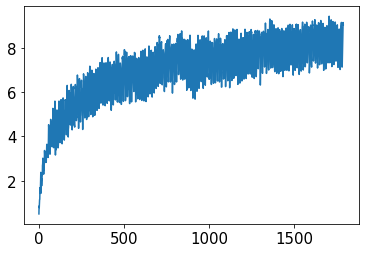

In [24]:
%matplotlib inline

plt.plot(cosa)

In [25]:
kernel.lwkernel.shape

(12, 24, 73, 144)

In [26]:
anoms_ok.shape

(1788, 24, 73, 144)

Calculating the feedback:

In [27]:
dRt = xr.apply_ufunc(lambda x, ker: x*ker, anoms_ok.groupby('time.month'), kernel) * vlevs.dp / 100.
dRt_int = dRt.sum('player')
dRt_int_yr = dRt_int.groupby('time.year').mean('time')
dRt_int_yr = dRt_int_yr['lwkernel']
dRt_int_yr_glob = ctl.global_mean(dRt_int_yr)

gtas = cosa.groupby('time.year').mean('time')

plt.plot(gtas, dRt_int_yr_glob)

In [39]:
from scipy import stats

res = stats.linregress(gtas, dRt_int_yr_glob)

print(res.slope, res.stderr, res.intercept, res.pvalue)

-1.9689234669528712 0.02807551850466734 1.0401150078799564 6.825221625459789e-115


This is a sum of the Planck feedback (from the atmospheric temperature profile, excluding surface for now) and of the lapse-rate feedback. To separate the contributions, should first compute the vertical mean anomaly, and then the lapse-rate anomaly.

In [42]:
anoms_mea = anoms_ok.mean('player')
anoms_lr = anoms_ok - anoms_mea

anoms_unif = anoms_ok - anoms_lr

In [43]:
dRt_unif = (xr.apply_ufunc(lambda x, ker: x*ker, anoms_unif.groupby('time.month'), kernel) * vlevs.dp / 100.).sum('player').groupby('time.year').mean('time')['lwkernel']

dRt_lr = (xr.apply_ufunc(lambda x, ker: x*ker, anoms_lr.groupby('time.month'), kernel) * vlevs.dp / 100.).sum('player').groupby('time.year').mean('time')['lwkernel']

dRt_unif_glob = ctl.global_mean(dRt_unif)
dRt_lr_glob = ctl.global_mean(dRt_lr)

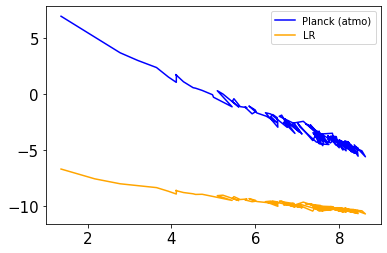

In [45]:
plt.plot(gtas, dRt_unif_glob, color = 'blue', label = 'Planck (atmo)')
plt.plot(gtas, dRt_lr_glob, color = 'orange', label = 'LR')
plt.legend()

In [1]:
res_unif = stats.linregress(gtas, dRt_unif_glob)
res_lr = stats.linregress(gtas, dRt_lr_glob)

print('Planck (atmo) feedback = {:6.2f} +/- {:6.2f} W/m^2/K'.format(res_unif.slope, res_unif.stderr))
print('Lapse-rate feedback = {:6.2f} +/- {:6.2f} W/m^2/K'.format(res_lr.slope, res_lr.stderr))

NameError: name 'stats' is not defined

### Tests for cloud feedback

In [1]:
kernel = allkers[('cld', 't')]

exp = 5

varnam = 'tas'
filist = glob.glob(filin_4c.format(5, varnam))
filist.sort()
tas = xr.open_mfdataset(filist)['tas']
gtas = ctl.global_mean(tas).groupby('time.year').mean('time')-pimean[(exp, 'tas')]['tas']

varnam = 'rlut'
filist = glob.glob(filin_4c.format(5, varnam))
filist.sort()
rlut = xr.open_mfdataset(filist)['rlut']

varnam = 'rsut'
filist = glob.glob(filin_4c.format(5, varnam))
filist.sort()
rsut = xr.open_mfdataset(filist)['rsut']

varnam = 'rsutcs'
filist = glob.glob(filin_4c.format(5, varnam))
filist.sort()
rsutcs = xr.open_mfdataset(filist)['rsutcs']

varnam = 'rlutcs'
filist = glob.glob(filin_4c.format(5, varnam))
filist.sort()
rlutcs = xr.open_mfdataset(filist)['rlutcs']

###

N = - rlut - rsut
N0 = - rsutcs - rlutcs

crf = (N - N0) # Crf is negative
crf = crf.groupby('time.year').mean('time')

N = N.groupby('time.year').mean('time')
N0 = N0.groupby('time.year').mean('time')

#var_mean = var.groupby('time.month').mean()

#var = ctl.regrid_dataset(var, kernel.lat, kernel.lon)
#pivar = ctl.regrid_dataset(pimean[(exp, varnam)], kernel.lat, kernel.lon)

NameError: name 'allkers' is not defined

In [13]:
crf_glob = ctl.global_mean(crf).compute()
N_glob = ctl.global_mean(N).compute()
N0_glob = ctl.global_mean(N0).compute()

In [11]:
%matplotlib inline
from scipy import stats

In [40]:
gtas = ctl.global_mean(tas).groupby('time.year').mean('time')

In [41]:
pitas = ctl.global_mean(pimean[(exp, 'tas')]['tas']).mean('month')

In [38]:
pitas.compute()

<xarray.DataArray 'tas' ()>
array(286.80571915)
Coordinates:
    height   float64 2.0

In [42]:
gtas = gtas - pitas
gtas = gtas.compute()

In [43]:
gtas

<xarray.DataArray 'tas' (year: 149)>
array([1.2062882 , 1.97185731, 2.55919572, 2.87155785, 3.256961  ,
       3.5230053 , 3.63626551, 3.56489257, 3.58661613, 3.78082503,
       4.02008176, 4.0755318 , 4.19591957, 4.35593471, 4.4674735 ,
       4.73206328, 4.30372989, 4.49891445, 4.82172809, 4.67125367,
       4.68455972, 4.83062578, 4.91756021, 4.94689216, 5.1055169 ,
       5.14053065, 4.96464704, 5.13683652, 5.17035064, 5.3414496 ,
       5.57490152, 5.37719559, 5.36045243, 5.48370906, 5.61188642,
       5.24595622, 5.31635646, 5.73526708, 5.66794293, 5.43462888,
       5.43569834, 5.71931545, 5.74369125, 5.72595593, 5.64462151,
       5.63674803, 5.9360966 , 5.68001448, 5.53156941, 5.65440627,
       5.92994127, 5.66570024, 5.61279754, 5.85431592, 6.00218105,
       5.73296133, 5.81324912, 6.09529664, 6.2864114 , 6.33397077,
       5.87653632, 5.8526536 , 6.19637378, 6.39612554, 6.13080033,
       5.91857486, 6.06781759, 6.36416499, 6.51506175, 6.3004344 ,
       6.29515852, 6.43893931, 6.13964543, 6.29018627, 6.21842035,
       5.83477048, 5.97614968, 6.37647782, 6.41497851, 6.19943915,
       6.24149435, 6.32357051, 6.58782855, 6.43075525, 6.18115759,
       6.21539065, 6.23807749, 6.45671256, 6.49934537, 6.1774224 ,
       6.25109052, 6.34947187, 6.47803572, 6.35221009, 6.47083653,
       6.64858824, 6.4321823 , 6.39654772, 6.39806902, 6.50999523,
       6.51291848, 6.51807694, 6.62688646, 6.67342938, 6.41841898,
       6.48755088, 6.69776307, 6.7798217 , 6.46823585, 6.58288015,
       6.84698934, 6.65068426, 6.74698831, 6.96179636, 6.74125044,
       6.59627388, 6.61357639, 6.78465426, 6.83013784, 6.51846108,
       6.59140496, 6.82143926, 6.89217877, 6.64158997, 6.65557786,
       6.8564609 , 6.87507664, 6.54353238, 6.63233129, 6.83794988,
       6.96726768, 6.95031321, 6.6793945 , 6.8864039 , 6.89171375,
       6.88138819, 6.87465898, 6.8964934 , 6.99178497, 6.74508385,
       6.69496659, 7.0510343 , 7.14553686, 6.82480715, 6.97519611,
       7.04470416, 6.69828863, 6.70607169, 7.00142389])
Coordinates:
    height   float64 2.0
  * year     (year) int64 1850 1851 1852 1853 1854 ... 1994 1995 1996 1997 1998

N - slope: $ -0.91 \pm   0.03$, intercept: $-333.07 \pm   0.18$
N0 - slope: $ -0.83 \pm   0.01$, intercept: $-315.00 \pm   0.06$
Crf - slope: $ -0.08 \pm   0.03$, intercept: $-18.07 \pm   0.15$


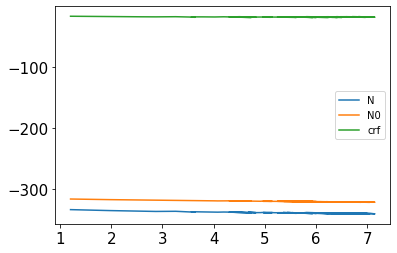

In [44]:
plt.plot(gtas, N_glob, label = 'N')
plt.plot(gtas, N0_glob, label = 'N0')
plt.plot(gtas, crf_glob, label = 'crf')
plt.legend()

res_N = stats.linregress(gtas, N_glob)
res_N0 = stats.linregress(gtas, N0_glob)
res_crf = stats.linregress(gtas, crf_glob)

for nam, res in zip(['N', 'N0', 'Crf'], [res_N, res_N0, res_crf]):
    print(r'{} - slope: ${:6.2f} \pm {:6.2f}$, intercept: ${:6.2f} \pm {:6.2f}$'.format(nam, res.slope, res.stderr, res.intercept, res.intercept_stderr))

### Now, reading the feedbacks from the other script, and calculating the cloud feedbacks

In [46]:
import pickle
feedbacks = pickle.load(open(cart_out + 'feedbacks_tunecs.p', 'rb'))

In [8]:
F0 = -315 + pimean[(exp, 'rlutcs')]['rlutcs'] + pimean[(exp, 'rsutcs')]['rsutcs']
F = -333.07 + pimean[(exp, 'rlut')]['rlut'] + pimean[(exp, 'rsut')]['rsut']

NameError: name 'pimean' is not defined

In [ ]:
F0.compute()
F.compute()

In [55]:
F_glob = ctl.global_mean(F).mean('month')
F0_glob = ctl.global_mean(F0).mean('month')

In [57]:
F_glob = F_glob.compute()
F0_glob = F0_glob.compute()

In [59]:
F0_glob-F_glob

<xarray.DataArray ()>
array(1.07590874)

In [68]:
fbnams = ['planck-surf', 'planck-atmo', 'lapse-rate', 'water-vapor', 'albedo']

fb_coef = dict()

for tip in ['clr', 'cld']:
    print('\n -------------- {} ---------------- \n'.format(tip))
    for fbn in fbnams:
        for exp in [5, 9]:
            gtas = feedbacks[(exp, 'gtas')]
            coso = feedbacks[(exp, tip, fbn)]

            res = stats.linregress(gtas, coso)
            fb_coef[(exp, tip, fbn)] = res

            print('{} feedback, exp {} = {:6.2f} +/- {:6.2f} W/m^2/K'.format(fbn, exp, res.slope, res.stderr))


 -------------- clr ---------------- 

planck-surf feedback, exp 5 =  -1.22 +/-   0.00 W/m^2/K
planck-surf feedback, exp 9 =  -1.21 +/-   0.00 W/m^2/K
planck-atmo feedback, exp 5 =  -1.79 +/-   0.02 W/m^2/K
planck-atmo feedback, exp 9 =  -1.87 +/-   0.01 W/m^2/K
lapse-rate feedback, exp 5 =  -0.43 +/-   0.01 W/m^2/K
lapse-rate feedback, exp 9 =  -0.44 +/-   0.01 W/m^2/K
water-vapor feedback, exp 5 =   2.14 +/-   0.03 W/m^2/K
water-vapor feedback, exp 9 =   2.25 +/-   0.02 W/m^2/K
albedo feedback, exp 5 =    nan +/-    nan W/m^2/K
albedo feedback, exp 9 =    nan +/-    nan W/m^2/K

 -------------- cld ---------------- 

planck-surf feedback, exp 5 =  -0.68 +/-   0.00 W/m^2/K
planck-surf feedback, exp 9 =  -0.69 +/-   0.00 W/m^2/K
planck-atmo feedback, exp 5 =  -1.99 +/-   0.02 W/m^2/K
planck-atmo feedback, exp 9 =  -2.07 +/-   0.01 W/m^2/K
lapse-rate feedback, exp 5 =  -0.57 +/-   0.01 W/m^2/K
lapse-rate feedback, exp 9 =  -0.58 +/-   0.01 W/m^2/K
water-vapor feedback, exp 5 =   1.87 +

/home/fabiano/local_bin/anaconda3/envs/ctl4/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/home/fabiano/local_bin/anaconda3/envs/ctl4/lib/python3.9/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


In [71]:
fb_cloud = res_crf.slope + np.nansum([fb_coef[(exp, 'clr', fbn)].slope - fb_coef[(exp, 'cld', fbn)].slope for fbn in fbnams]) + (F0_glob - F_glob)/gtas[-5:].mean()

In [72]:
fb_cloud

<xarray.DataArray ()>
array(0.16617599)
Coordinates:
    height   float64 2.0

### Final plots

In [3]:
import pickle

feedbacks = pickle.load(open(cart_out + 'feedbacks_tunecs.p', 'rb'))
fb_coef = pickle.load(open(cart_out + 'fb_coef_tunecs.p', 'rb'))

In [4]:
fb_coef[(5, 'cloud')], fb_coef[(9, 'cloud')]

(0.2547572168540026, 0.27461535352185434)

In [5]:
fb_coef[(5, 'cloud_err')], fb_coef[(9, 'cloud_err')]

(0.04323981517820741, 0.03790914453690784)

In [6]:
fb_coef[(5, 'tot')],fb_coef[(9, 'tot')]

(-0.403773393584463, -0.44404271343870866)

In [5]:
fb_coef.keys()

dict_keys([(5, 'clr', 'planck-surf'), (9, 'clr', 'planck-surf'), (5, 'clr', 'planck-atmo'), (9, 'clr', 'planck-atmo'), (5, 'clr', 'lapse-rate'), (9, 'clr', 'lapse-rate'), (5, 'clr', 'water-vapor'), (9, 'clr', 'water-vapor'), (5, 'clr', 'albedo'), (9, 'clr', 'albedo'), (5, 'cld', 'planck-surf'), (9, 'cld', 'planck-surf'), (5, 'cld', 'planck-atmo'), (9, 'cld', 'planck-atmo'), (5, 'cld', 'lapse-rate'), (9, 'cld', 'lapse-rate'), (5, 'cld', 'water-vapor'), (9, 'cld', 'water-vapor'), (5, 'cld', 'albedo'), (9, 'cld', 'albedo'), (5, 'cloud'), (5, 'cloud_err'), (9, 'cloud'), (9, 'cloud_err'), (5, 'tot'), (5, 'tot_err'), (9, 'tot'), (9, 'tot_err')])

In [ ]:
%matplotlib inline

fig, ax = plt.subplots(figsize = (12,8))
for i, fb in enumerate(['planck-surf', 'planck-atmo', 'lapse-rate', 'water-vapor', 'albedo']):
    ax.scatter()
    

In [6]:
fbnams = ['planck-surf', 'planck-atmo', 'lapse-rate', 'water-vapor', 'albedo']

for tip in ['clr', 'cld']:
    print('\n -------------- {} ---------------- \n'.format(tip))
    for fbn in fbnams:
        for exp in [5, 9]:
            res = fb_coef[(exp, tip, fbn)]

            print('{} feedback, exp {} = {:6.2f} +/- {:6.2f} W/m^2/K'.format(fbn, exp, res.slope, res.stderr))


 -------------- clr ---------------- 

planck-surf feedback, exp 5 =  -1.22 +/-   0.00 W/m^2/K
planck-surf feedback, exp 9 =  -1.21 +/-   0.00 W/m^2/K
planck-atmo feedback, exp 5 =  -2.44 +/-   0.01 W/m^2/K
planck-atmo feedback, exp 9 =  -2.47 +/-   0.01 W/m^2/K
lapse-rate feedback, exp 5 =   0.22 +/-   0.02 W/m^2/K
lapse-rate feedback, exp 9 =   0.16 +/-   0.01 W/m^2/K
water-vapor feedback, exp 5 =   2.14 +/-   0.03 W/m^2/K
water-vapor feedback, exp 9 =   2.25 +/-   0.02 W/m^2/K
albedo feedback, exp 5 =   0.97 +/-   0.01 W/m^2/K
albedo feedback, exp 9 =   0.88 +/-   0.01 W/m^2/K

 -------------- cld ---------------- 

planck-surf feedback, exp 5 =  -0.68 +/-   0.00 W/m^2/K
planck-surf feedback, exp 9 =  -0.69 +/-   0.00 W/m^2/K
planck-atmo feedback, exp 5 =  -2.76 +/-   0.00 W/m^2/K
planck-atmo feedback, exp 9 =  -2.78 +/-   0.00 W/m^2/K
lapse-rate feedback, exp 5 =   0.21 +/-   0.02 W/m^2/K
lapse-rate feedback, exp 9 =   0.13 +/-   0.02 W/m^2/K
water-vapor feedback, exp 5 =   1.87 +